In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

In [16]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


Creating a TF dataset from image files in a directory

In [3]:
#lego brick dataset
directory = r"C:\Users\Jayde\Desktop\lego-brick-data\dataset"
#also resizes the images to 64x64 (from 400x400), interpolating between pixel values
train_data = utils.image_dataset_from_directory(directory,
                                               labels=None,
                                               color_mode="grayscale",
                                               image_size=(64,64),
                                               batch_size=128,
                                               shuffle=True,
                                               seed=42,
                                               interpolation="bilinear")

Found 40000 files belonging to 1 classes.


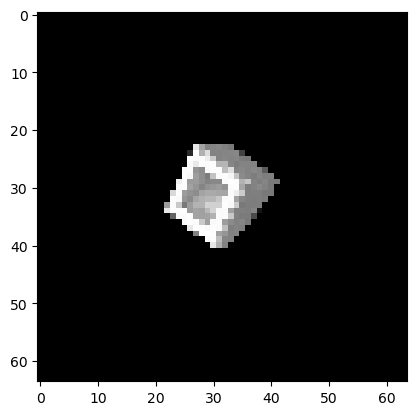

In [7]:
sample = train_data.take(1).get_single_element()
#this takes 1 batch, sample.shape = [128,64,64,1] = [n_batches,xdim,ydim,channels]
sample=sample[0] #one sample out of the batch
sample=sample.numpy() #tensorflow tensor to numpy array
plt.imshow(sample, cmap="gray")

Preprocessing
. Rescaling from [0,255] to [-1,1] (so we can use tanh activation function on final layer of generator)

In [8]:
def preprocess(img):
    img= (tf.cast(img,"float32") - 127.5) / 127.5 #tf.cast changes the tensor datatype 
    return img

In [9]:
#train = train_data.map(lambda x: preprocess(x))
train = train_data.map(preprocess)
train

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)>

# Discriminator

In [10]:
dis_input =layers.Input(shape = (64,64,1)) #input layer shape (size, channels (1 for greyscale))
x = layers.Conv2D(64, kernel_size = 4, strides = 2, padding= "same", use_bias = False)(dis_input)
#conv layer 64 channels (increased from 1), strides of 2 halves spacial tensor size (64 -> 32)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x) # for dropout regularization

#32
x = layers.Conv2D(128, kernel_size = 4, strides = 2, padding= "same", use_bias = False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

#16
x = layers.Conv2D(256, kernel_size = 4, strides = 2, padding= "same", use_bias = False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

#8
x = layers.Conv2D(512, kernel_size = 4, strides = 2, padding= "same", use_bias = False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

#4
#final conv layer with sigmoid activation to output a number between 0 and 1
x = layers.Conv2D(1, kernel_size = 4, strides = 1, padding= "valid", use_bias = False, activation = 'sigmoid')(x)

#flatten the last conv layer (shape of 1,1,1 to 1d array)
dis_output = layers.Flatten()(x)

discriminator = models.Model(dis_input, dis_output, name="discriminator")

In [11]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                     

# Generator

The input to the generator is a vector drwan from a mulitivariate standard normal distribution

In [12]:
gen_input = layers.Input(shape=(100,)) # input vector of legnth 100
x = layers.Reshape((1,1,100))(gen_input) # now a 1x1x100 tensor, can now apply convolutional transpose operations

#basically now just the reverse of the discriminator
x= layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias= False)(x)
x= layers.BatchNormalization(momentum=0.9)(x)
x= layers.LeakyReLU(0.2)(x)

x= layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias= False)(x)
x= layers.BatchNormalization(momentum=0.9)(x)
x= layers.LeakyReLU(0.2)(x)

x= layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias= False)(x)
x= layers.BatchNormalization(momentum=0.9)(x)
x= layers.LeakyReLU(0.2)(x)

x= layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias= False)(x)
x= layers.BatchNormalization(momentum=0.9)(x)
x= layers.LeakyReLU(0.2)(x)

#tanh activation to transform the output to range [-1,1] to match the origional domain
gen_output = layers.Conv2DTranspose(1, kernel_size = 4, strides=2, padding = "same", use_bias = False, activation = 'tanh')(x)

generator = models.Model(gen_input, gen_output, name= "generator")

In [13]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        20

Alternative to conv2d transpose layers is to use upsampling2d followed my normal conv2d layer with stride 1.

x = layers.UpSampling2D(size = 2)(x)

x= layers.Conv2D(256, kernel_size=4, strides=1, padding="same")(x)

# Training

In [14]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training = True
            )
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(generated_images, training = True)
            
            real_labels = tf.ones_like(real_predictions) #creates a tensor with shape of real_predictions with all values set to 1
            #label smoothing
            real_noisy_labels = real_labels + 0.1*tf.random.uniform(tf.shape(real_predictions))
            
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels + 0.1*tf.random.uniform(tf.shape(fake_predictions))
            
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            
            g_loss = self.loss_fn(real_labels, fake_predictions)
        
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )
        
        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}

In [15]:
dcgan = DCGAN(discriminator = discriminator, generator = generator, latent_dim=100)

dcgan.compile(
    d_optimizer = optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999),
    g_optimizer = optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999)
)

dcgan.fit(train, epochs=100, verbose = True)

Epoch 1/100
 14/313 [>.............................] - ETA: 44:41 - d_loss: 0.1300 - g_loss: 2.1020

KeyboardInterrupt: 